# Prototype Hyperspecctral Class

In [992]:
import glob, os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage.measure import label, regionprops
from PIL import Image 

## Module

#### Metadata

In [993]:
def datastore_metadata( path_to_images ):
    """Prepare metadata on datastore"""
    image_map_files = []
    for file in os.listdir( path_to_images ):
        if file.endswith( ".png" ):
            image_map_files.append(file)
    df = pd.DataFrame(image_map_files, columns=["filename"])

    identifiers = parse_identifier( df )

    depths = parse_depths( df )

    image_metadata = pd.concat([df, identifiers, depths], axis=1)

    image_metadata = image_metadata\
        .sort_values(by="box-id")\
        .reset_index( drop=True )
    return image_metadata


def parse_identifier(df):
    """Parse identifier string in mineralmap and mask filenames"""
    identifiers = df["filename"]\
        .str.extract("CMM-(.*)@",expand=False)\
        .str.split("_", expand=True)\
        .astype("int")
    identifiers.columns = ["core-id", "box-id"] 
    return identifiers


def parse_depths(df):
    """Parse depth string in mineralmap and mask filenames"""
    depths = df["filename"]\
        .str.extract("@(.*).png",expand=False)\
        .str.split("_", expand=True)\
        .astype("float")
    depths.columns = ["depth-start", "depth-end"] 
    return depths 

#### Datastore I/O

In [994]:
def read_images(path_to_images, image_names, mode="all"):
    """Read images into an ndarray array"""

    if mode == "sample":
     n = 5
    elif mode == "all":
        n = len(image_names)
    else:
        raise Exception("Unknown mode selection. Select sample or all.")
    images = [None] * n
    for i in range(0,n):
        images[i] = np.array( 
            Image.open( os.path.join(path_to_images,  image_names[i]) ) 
            )  
    return images


def read_datastore( path_to_images, mode="sample"):
    """Read image datastore"""

    image_metadata = datastore_metadata( path_to_images )
    image_names = image_metadata["filename"]
    images = read_images(path_to_images, image_names, mode=mode)

    return images

def qc_maskdata( masks ):
    for i in range( len(masks) ):
        if len(masks[i].shape) > 2:
            masks[i]=masks[i][:,:,0]
    return masks

#### Mineral map calcs

In [995]:
def mask_image( image ):
    """Mask background pixels of minalyze map image"""
    mask = np.all(image == (0,0,0), axis=-1)
    image_masked = np.copy( image )
    image_masked[mask,:]= [255, 255, 255]

    return image_masked 


def identify_box( mask ):
    """Identify core box columns as mask"""
    bg = np.sum(mask==False, axis=0) == mask.shape[0]
    core_column = label( np.invert(bg) )
    return core_column


def segment_box( box, compartment_mask ):
    """Segment core box""" 
    n_column = np.max( np.unique(compartment_mask) )
    n = n_column+1

    array = [None] * n_column
    for i in range(1,n):
            array[i-1] = box[:, compartment_mask==i]
    return array 


def get_core_pixel_counts( mask, core_compartment ):
    """Get core pixel count per row per compartment"""

    compartments = segment_box( mask, core_compartment )

    n_row = compartments[0].shape[0] 
    n_column = len(compartments)
    n = n_column

    column_pixel_counts = np.zeros( (n_row,n_column ) )
    for j in range(0,n):
        column_pixel_counts[:,j] = np.sum( compartments[j], axis=1 )
    column_pixel_counts[column_pixel_counts==0] = np.nan
    return column_pixel_counts


def get_mineral_pixel_counts( image, mask, mineral_dictionary ):
    """Get all mineral pixel counts per row per compartment"""

    # segment core box mask into columns / compartments 
    core_compartments = identify_box( mask )

    # core pixel counts by row/compartment
    column_pixel_counts = get_core_pixel_counts( mask, core_compartments )

    # define tensor dimensions 
    n_row     = mask.shape[0] 
    n_column  = get_compartment_count( core_compartments )
    n_mineral = len( mineral_dictionary )
    n = n_column

    mineral_pixel_counts = np.zeros( (n_row, n_column, n_mineral) )

    #loop over minerals and core compartments 
    for k, (key,value) in enumerate( mineral_dictionary.items() ):
        mineral = np.all(image == value, axis=-1)
        compartments = segment_box( mineral, core_compartments )
        for j in range(0, n):
            mineral_pixel_counts[:,j,k] = np.sum(compartments[j],axis=1)
    return mineral_pixel_counts


def get_mineral_pixel_prc( mineral_pixel_counts, core_pixel_counts ):
    """Get all mineral pixel percentage per row per compartment"""
    mineral_pixel_prc = mineral_pixel_counts / core_pixel_counts[:,:, np.newaxis]
    return mineral_pixel_prc


def tensor_to_matrix(mineral_tensor):
    """Convert mineral tensor to a mineral matrix"""
    mineral_matrix = np.concatenate( mineral_tensor.transpose(1,0,2), axis=0)
    return mineral_matrix  


def get_compartment_count( compartment_mask ):
    """Number of core columns/compartments"""
    n_compartment = np.max( np.unique( compartment_mask ) )
    return n_compartment


#### Transform

In [996]:
def get_core_compartments( image, mask, astype="image" ):
    """Segment core box into array of core columns"""
    core_compartments = identify_box( mask )
    
    if astype == "image":
        array = segment_box( image, core_compartments )
    elif astype == "mask":
        array = segment_box( mask, core_compartments )
    else:
        array = None
    return array 


def compartment_to_column( compartments ):
    """Convert core box compartments to column"""

    nchannel = compartments[0].shape[2]
    nrow     = compartments[0].shape[0]  
    ncol     = np.array( [item.shape[1] for item in compartments] )

    to_pad = max(ncol) - ncol

    padded=[]
    for (item, value) in zip(compartments,to_pad):
        extra_left, extra_right=[
            np.floor(value/2).astype("int"),
            np.ceil(value/2).astype("int")
            ]
        array = np.pad(item,((0,0),(extra_left,extra_right),(0,0)), 
            mode="constant", constant_values=255)
        padded.append(array)
    column = np.concatenate(padded, axis=0)
    return column

#### Class

In [997]:
class HyperspecDatastore:
    """Import hyperspectral from datastore"""
    def __init__(self, path_to_mineral, path_to_mask ):
        """ImportHyperspec constructor"""
        self._active_index = 0 
        self._problem_index = []
        self._core_box_df = []
        self._core_box_column = []
        self.core_column = []
        self.core_df = []
        self.minerals = []
        self.masks = []
        self.metadata = []
        self.minerals_dictionary = []
        self.minerals_colormap = []
        self.path_to_mineral = path_to_mineral
        self.path_to_mask = path_to_mask
        
    @property
    def features(self):
        return list(self.minerals_dictionary.keys())

    def read_metadata(self):
        """Read metadata"""
        mineralmap_metadata = datastore_metadata( self.path_to_mineral )
        mask_metadata = datastore_metadata( self.path_to_mask )

        mineralmap_metadata = mineralmap_metadata.rename(columns={
            "filename": "mineral_filename",
            })
        mask_metadata = mask_metadata.rename(columns={
            "filename": "mask_filename",
            })

        joining_variables = ["core-id", "box-id", "depth-start", "depth-end"]
        metadata = mineralmap_metadata.merge(mask_metadata,
            how = "inner", 
            left_on = joining_variables,
            right_on = joining_variables)

        this = metadata.pop( "mineral_filename" )
        metadata.insert(metadata.columns.get_loc("mask_filename"), 
            "mineral_filename", this)

        metadata["box-id"] = metadata["box-id"].astype("int64")

        metadata = metadata.set_index("box-id")

        self.metadata = metadata

    def read_legend(self):
        """Read legend containing mineral map color scheme."""
        legend = np.array( 
            Image.open( os.path.join(self.path_to_mineral, ".." ,  "mineral-legend.png") ) 
            )
        points_to_sample =np.array([
            [17,86],
            [17, 112],
            [17,136],
            [17,158],
            [17,184],
            [17,209],
            [17,235],
            ])
        mineral_keys = [
            "illite",
            "illite-smectite",
            "low-reflectance",
            "montmorillonite",
            "other",
            "smectite-kaolinite",
            "smectite-saponite",
            ]

        pixel_values = []
        pixel_values_scaled = [] 
        for row in points_to_sample:
            value = legend[row[1],row[0]][:3]
            pixel_values.append( tuple(value) )
            pixel_values_scaled.append( tuple(value/255) )
        pixel_values
        mineral_categories = dict( zip(mineral_keys, pixel_values) )
        self.minerals_dictionary = mineral_categories
        self.minerals_colomap = pixel_values_scaled

    def read(self, mode="all"):
        """Read datastore"""

        #read/construct metadata
        self.read_metadata()

        #read mineralmap color scheme
        self.read_legend()

        #read minerals
        image_names = self.metadata["mineral_filename"].values
        self.minerals = np.array( read_images(self.path_to_mineral, image_names, mode=mode ), dtype="object" )
        
        #read masks 
        image_names = self.metadata["mask_filename"].values
        self.masks  = np.array( qc_maskdata( read_images(self.path_to_mask, image_names, mode=mode ) ), dtype="object" )

    def extract_features(self):
        """TODO"""
        n = len(self.minerals)

        self._problem_index = []
        features = []
        for i in range( n ):
            self._active_index = i
            self.calculate_metrics()
            if len(self._core_box_df)==0:
                self._problem_index.append(i)
            features.append(self._core_box_df)
        self.core_df = pd.concat( features ).set_index("box-id")

    def calculate_metrics(self):
        """Calculate mineral map metrics"""

        mineral = mask_image( self.minerals[self._active_index] )
        mask    = self.masks[ self._active_index ]
        
        #identify core compartments
        core_compartments = identify_box( mask )

        #core pixel curve
        core_pixel_counts = get_core_pixel_counts( 
            mask, 
            core_compartments )

        try:
            #mineral pixel counts 
            mineral_pixel_counts = get_mineral_pixel_counts( 
                mineral, 
                mask, 
                self.minerals_dictionary)

            # mineral pixel prc
            mineral_pixel_prc = get_mineral_pixel_prc( 
                mineral_pixel_counts, 
                core_pixel_counts )

            # mineral metric curves
            mineral_metrics = tensor_to_matrix( mineral_pixel_prc )
        except:
            df = pd.DataFrame()
        else:
            # create core_box
            df = pd.DataFrame( 
                mineral_metrics, 
                columns=self.minerals_dictionary.keys() )

            core_box         = self.metadata.index[self._active_index]
            core_start_depth = self.metadata["depth-start"].iloc[self._active_index]
            core_end_depth   = self.metadata["depth-end"].iloc[self._active_index]
            n_pixels = df.shape[0]

            #TODO revisit and calculate resolution 
            core_depth = np.linspace(
                core_start_depth, 
                core_end_depth, 
                n_pixels)

            df.insert(0, 
                "core_depth", core_depth)

            df.insert(0, 
                "box-id",
                np.ones((df.shape[0],1), dtype="int64")*core_box)

        self._core_box_df = df

    def get_core_column(self):
        """"""
        n = len(self.minerals)
        columns = []
        for i in range( n ):
            self._active_index = i
            self.get_core_box_column()
            columns.append( self._core_box_column  )
        self.core_column = compartment_to_column( columns )


    def get_core_box_column(self):
        """TODO"""

        mineral = mask_image( self.minerals[self._active_index] )
        mask    = self.masks[ self._active_index ]
        compartments = get_core_compartments(mineral, mask)
        core_column = compartment_to_column( compartments )
        self._core_box_column = core_column

    def plot_core_box(self, box_id, ptype="minerals"):
        """Preview core box image array"""
        
        images = getattr(self, ptype)
        images = images[box_id]
        n = len(images)

        fig, ax  = plt.subplots(1,n, figsize=(18,12))
        for item,image in zip(ax,images):
            item.imshow(image, interpolation="none")

    def plot_core_box_features( self, box_id ):
        """Plot mineral features"""

        minerals = self.core_df.loc[box_id,self.features]
        core_depth = self.core_df.loc[box_id,"core_depth"]
        mineral_keys = minerals.columns.values

        n_element = minerals.shape[1]
        fig, ax = plt.subplots(1,n_element, figsize=(18,12), sharey=True)
        for i in range( len(ax) ):
            mineral = minerals.iloc[:,i]
            ax[i].plot(mineral, core_depth)
            ax[i].set_title(mineral_keys[i])
        ax[0].invert_yaxis()
        ax[0].set_ylabel( "core depth" )
        return ax

    def plot_core_features(self, minimap=False):
        """TODO"""

        minerals = self.core_df.loc[:,self.features]
        core_depth = self.core_df["core_depth"]
        mineral_keys = minerals.columns.values
        n_element = minerals.shape[1]

        if minimap==True:
            fig, ax = plt.subplots(1,n_element+1, figsize=(18,12), sharey=True)
            index = self.core_df.shape[0]-1
            core_start = self.core_df["core_depth"].iloc[0]
            core_end = self.core_df["core_depth"].iloc[index]
            ax[0].imshow(ds.core_column, interpolation="none", aspect=.5, extent=[0,50,core_end,core_start])
            for i in range( 1,n_element+1 ):
                mineral = minerals.loc[:,mineral_keys[i-1]]
                ax[i].plot(mineral, core_depth)
                ax[i].set_title(mineral_keys[i-1])

        else:
            fig, ax = plt.subplots(1,n_element, figsize=(18,12), sharey=True)
            for i in range( len(ax) ):
                mineral = minerals.loc[:,mineral_keys[i]]
                ax[i].plot(mineral, core_depth)
                ax[i].set_title(mineral_keys[i])
            ax[0].invert_yaxis()
        ax[0].set_ylabel( "core depth" )
        return ax
        

    def plot_core_column(self):
        """Plot core box column"""

        index = self.core_df.shape[0]-1
        
        core_start = self.core_df["core_depth"].iloc[0]
        core_end = self.core_df["core_depth"].iloc[index]

        fig, ax  = plt.subplots(1,1, figsize=(18,12))
        ax.imshow(ds.core_column, interpolation="none", aspect=1, extent=[0,50,core_end,core_start])
        ax.set_ylabel("core depth")


    @classmethod
    def read_ds( cls, path_to_mineral, path_to_mask, mode="all" ):
        """Read hyperspectral datastore"""
        ds = cls(path_to_mineral, path_to_mask)
        ds.read(mode=mode)
        return ds


In [998]:
ds.core_df["core_depth"].iloc[ds.core_df.shape[0]-1]

2091.5

## Configure

In [999]:
path_to_data    = "../../data/cmm-111C-coremask-mineralmap/"
path_to_mineral = os.path.join(path_to_data, "borehole-mineral-map")
path_to_mask    = os.path.join(path_to_data, "core-mask")

## Prototype: all core boxes

Read the mineral map and core mask datastore

In [1000]:
ds = HyperspecDatastore.read_ds(path_to_mineral, path_to_mask, mode="all")

Preview datastore metadata 

In [1001]:
ds.metadata

,core-id,depth-start,depth-end,mineral_filename,mask_filename
box-id,,,,,
1,111,0.0,10.0,Borehole_Mineral_MAP__VN-SWIR__CMM-111_1@0_10.png,Core_Mask__VN-SWIR__CMM-111_1@0_10.png
2,111,10.0,19.5,Borehole_Mineral_MAP__VN-SWIR__CMM-111_2@10_19...,Core_Mask__VN-SWIR__CMM-111_2@10_19.5.png
3,111,19.5,28.5,Borehole_Mineral_MAP__VN-SWIR__CMM-111_3@19.5_...,Core_Mask__VN-SWIR__CMM-111_3@19.5_28.5.png
4,111,28.5,37.5,Borehole_Mineral_MAP__VN-SWIR__CMM-111_4@28.5_...,Core_Mask__VN-SWIR__CMM-111_4@28.5_37.5.png
5,111,37.5,47.5,Borehole_Mineral_MAP__VN-SWIR__CMM-111_5@37.5_...,Core_Mask__VN-SWIR__CMM-111_5@37.5_47.5.png
...,...,...,...,...,...
234,111,2056.0,2064.0,Borehole_Mineral_MAP__VN-SWIR__CMM-111_234@205...,Core_Mask__VN-SWIR__CMM-111_234@2056_2064.png
235,111,2064.0,2074.5,Borehole_Mineral_MAP__VN-SWIR__CMM-111_235@206...,Core_Mask__VN-SWIR__CMM-111_235@2064_2074.5.png
236,111,2074.5,2081.5,Borehole_Mineral_MAP__VN-SWIR__CMM-111_236@207...,Core_Mask__VN-SWIR__CMM-111_236@2074.5_2081.5.png


Number of core boxes in datastore

In [1002]:
len(ds.minerals)

238

Preview core boxes using box-id

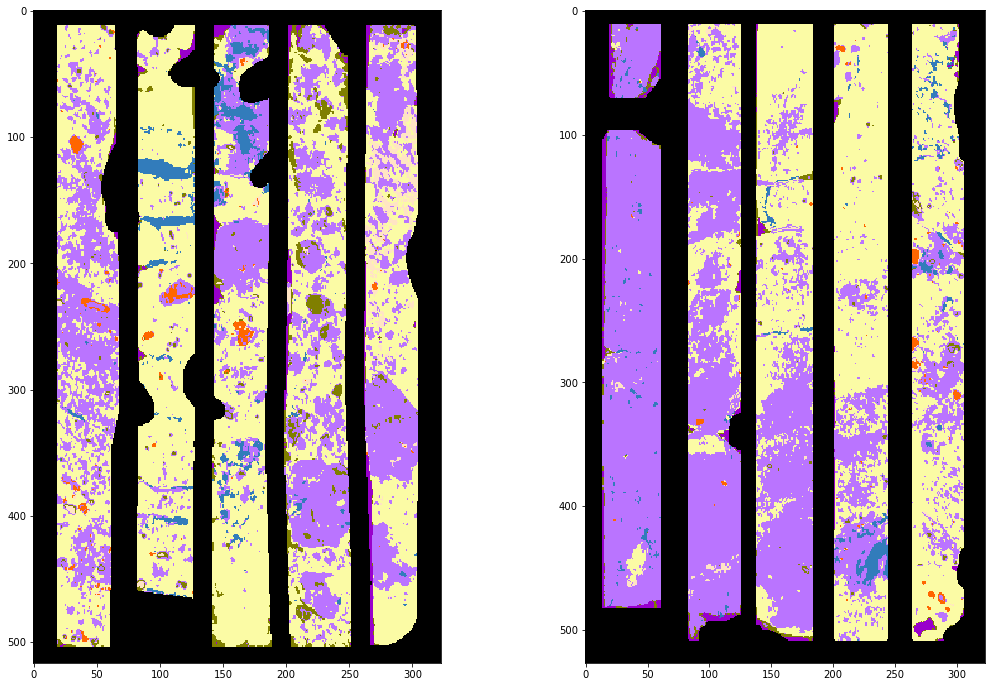

In [1003]:
ds.plot_core_box( box_id=[0,1])

Extract features. Mineral composition prc per depth 

In [1004]:
ds.extract_features()

In [1026]:
ds.core_df.loc[1].iloc[10:20]

,core_depth,illite,illite-smectite,low-reflectance,montmorillonite,other,smectite-kaolinite,smectite-saponite
box-id,,,,,,,,
1,0.038700,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.042570,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.046440,0.000000,0.847826,0.0,0.086957,0.0,0.0,0.065217
1,0.050310,0.000000,0.804348,0.0,0.108696,0.0,0.0,0.086957
1,0.054180,0.000000,0.804348,0.0,0.130435,0.0,0.0,0.065217
1,0.058050,0.021739,0.760870,0.0,0.173913,0.0,0.0,0.043478
1,0.061920,0.043478,0.782609,0.0,0.130435,0.0,0.0,0.043478
1,0.065789,0.043478,0.826087,0.0,0.065217,0.0,0.0,0.065217
1,0.069659,0.021739,0.847826,0.0,0.065217,0.0,0.0,0.065217


In [1006]:
ds.features 

['illite',
 'illite-smectite',
 'low-reflectance',
 'montmorillonite',
 'other',
 'smectite-kaolinite',
 'smectite-saponite']

Corner case (box-id = 25). Note the mask came in as 3D array. 

In [1007]:
if len(ds._problem_index)>0:
    ds.metadata.iloc[ds._problem_index]

Plot mineral composition (features) for the full core

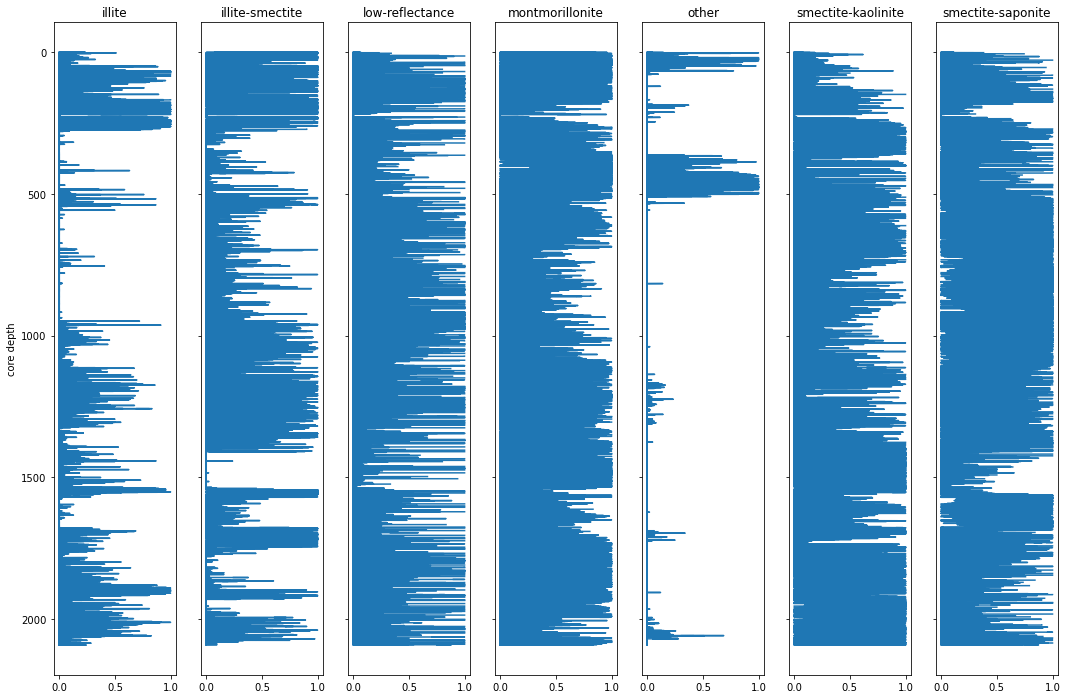

In [1008]:
ax = ds.plot_core_features(minimap=False)

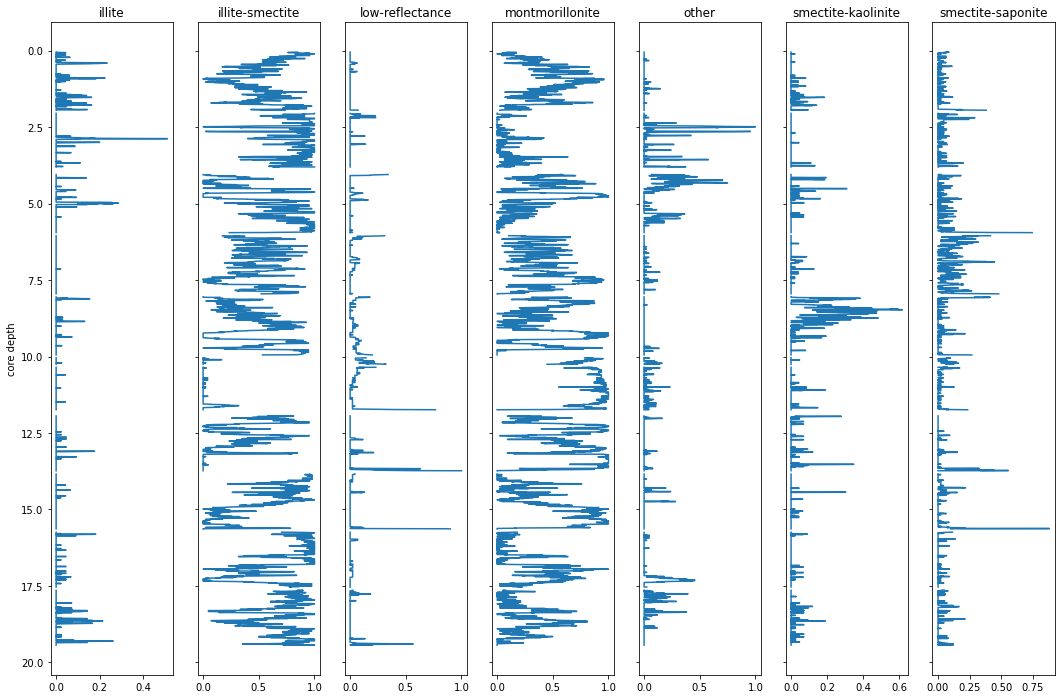

In [1009]:
ax = ds.plot_core_box_features( [1,2] )

In [1010]:
ds.get_core_column()

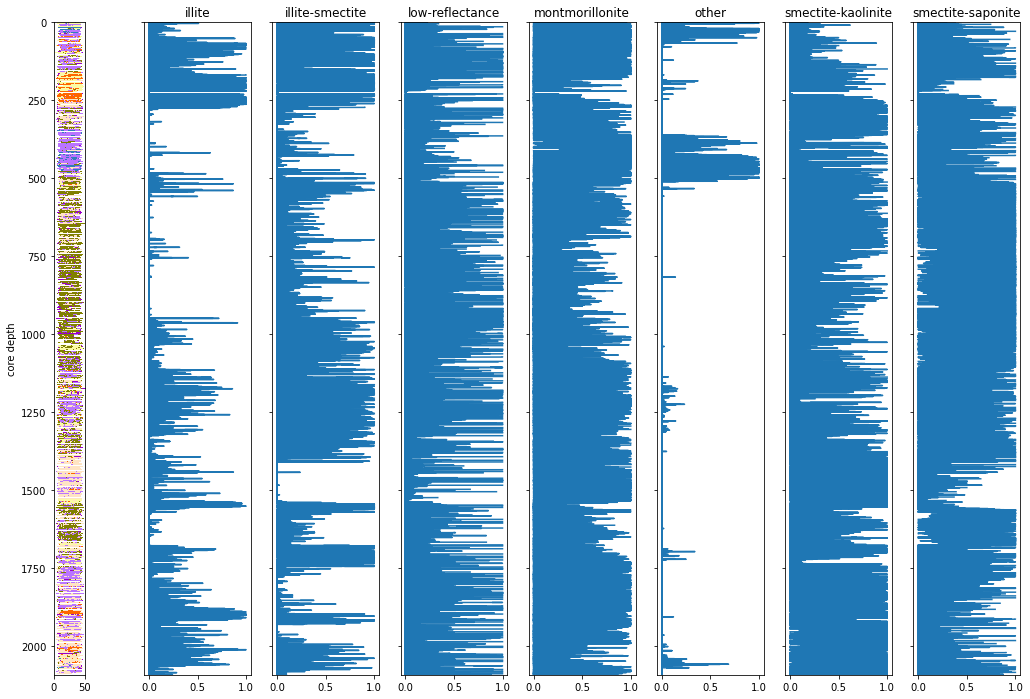

In [1011]:
ax = ds.plot_core_features(minimap=True)